In [1]:
import numpy as np

import numpy.random as npr
import random
from numpy.linalg import inv

#from causaltensor.cauest import DC_PR_with_suggested_rank
#from causaltensor.cauest import std_debiased_convex
#from causaltensor.cauest import DC_PR_auto_rank

# import causaltensor as ct
from helper_function import *
from algorithm import *
import ray
import time
import matplotlib.pyplot as plt
import pdb

In [2]:
%load_ext autoreload
%autoreload 2

In [46]:
vvv = np.random.binomial(1, 0.5, [20, 20])
vvvv = vvv @ vvv.T
np.linalg.matrix_rank(vvv)

20

## Testing full-rank H

In [51]:
dim = 200
d1 = dim
d2 = dim
r = 3
tau = 2
noise_sd = 0.5
seed = 1

@ray.remote
def one_run(seed, d1, d2, r, tau, noise_sd):
    b, z_vec, treat_mat, outcome_mat = generate_dat(seed, d1, d2, r, tau, noise_sd)
    O = outcome_mat
    Z = treat_mat
    u_t, s_t, vh_t = np.linalg.svd(b, full_matrices = False)
    h_z_vec = opt_instrument(z_vec, treat_mat)
    #h_z = np.random.binomial(1, 0.5, [d1, d2])
    h_z_vec = h_z.reshape([d1*d2, 1])
    P_Z = h_z_vec.dot(inv(h_z_vec.T.dot(h_z_vec)).dot(h_z_vec.T))
    O_corrected = np.reshape(P_Z.dot(outcome_mat.reshape([d1*d2, 1])), [d1, d2])
    Z_corrected = np.reshape(P_Z.dot(treat_mat.reshape([d1*d2, 1])), [d1, d2])
    M, tau, M_raw, tau_raw, t1, t2, l = DC_PR_with_suggested_rank(O_corrected, Z_corrected, suggest_r = r)
    return M, tau, M_raw, tau_raw, t1, t2, l

In [ ]:
n_iters = 50

ray.shutdown()
ray.init()

start_time = time.time()
all_results = ray.get(
   [
       one_run.remote(seed, d1, d2, r, tau, noise_sd) for seed in range(n_iters)
   ]
).copy()
ray.shutdown()
duration = time.time() - start_time

2023-08-15 01:26:47,906	INFO worker.py:1636 -- Started a local Ray instance.
2023-08-15 01:31:38,232	WARNING worker.py:2019 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: e6211224406a3ebdc3a78004f3ed5adaf5551db201000000 Worker ID: 5e57660d6d3fb2818cf7e8e4e9fd17009f5bd1d9a7d355ad18ebdc00 Node ID: 8f5a4b1d7fb37b8d3ca732f7dbe48b7759e58b711f11b4708b56f9f1 Worker IP address: 128.208.6.69 Worker port: 42841 Worker PID: 1107882 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned.
2023-08-15 01:31:38,383	WARNING worker.py:2019 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 7d75ec5c5625ca4bac29cd30e941b20ebf78692c01000000 Worker ID: 132a7c6f6319dba9569f74c82856319b754938

In [ ]:
#M, tau, M_raw, tau_raw = DC_PR_with_suggested_rank(O, Z, suggest_r = 2)
M_arr = [r[0] for r in all_results]
tau_arr = np.array([r[1] for r in all_results])
M_raw_arr = [r[2] for r in all_results]
tau_raw_arr = np.array([r[3] for r in all_results])
b_arr = [r[4] for r in all_results]
tau_mean = np.mean(tau_arr)
tau_sd = np.std(tau_arr)
tau_raw_mean = np.mean(tau_raw_arr)
tau_raw_sd = np.std(tau_raw_arr)
print("tau: ", tau_mean, tau_sd)
print("tau raw: ", tau_raw_mean, tau_raw_sd)

In [ ]:
print("hello!")

## Other tests

In [4]:
h_z = h_z_vec.reshape([d1, d2])

In [15]:
eigvals = np.linalg.eig(h_z)[0]
np.sum(eigvals >= 0.001)

24

In [23]:
z_mat = z_vec.reshape([d1, d2])
print(np.linalg.matrix_rank(z_mat))
print(np.amax(np.linalg.eig(z_mat)[0]))
print(np.linalg.norm(h_z_vec))

4
(3275.300973401064+0j)
135.65397155999526


In [20]:
err = O - b - tau * Z
err_corrected_1 = np.reshape(P_Z @ err.reshape([d1*d2, 1]), [d1, d2])

In [21]:
b_corrected = np.reshape(P_Z @ b.reshape([d1*d2, 1]), [d1, d2])
err_corrected_2 = O_corrected - b_corrected - tau * Z_corrected

In [25]:
dim_lst = [160, 140, 120, 100, 80, 60, 40, 20]
r = 3
tau = 2
noise_sd = 0.5
seed = 1
min_eig_b = []
min_eig_b_corrected = []
for dim in dim_lst:
    d1 = dim
    d2 = dim
    b, z_vec, treat_mat, outcome_mat = generate_dat(seed, d1, d2, r, tau, noise_sd)
    O = outcome_mat
    Z = treat_mat
    u_t, s_t, vh_t = np.linalg.svd(b, full_matrices = False)
    h_z_vec = opt_instrument(z_vec, treat_mat)
    P_Z = h_z_vec.dot(inv(h_z_vec.T.dot(h_z_vec)).dot(h_z_vec.T))
    O_corrected = np.reshape(P_Z.dot(outcome_mat.reshape([d1*d2, 1])), [d1, d2])
    Z_corrected = np.reshape(P_Z.dot(treat_mat.reshape([d1*d2, 1])), [d1, d2])
    min_eig_b.append(np.amin(np.linalg.eig(b)[0]))
    min_eig_b_corrected.append(np.amin(np.linalg.eig(b_corrected)[0]))
    print("dim={} completed.".format(dim))

dim=160 completed.
dim=140 completed.
dim=120 completed.
dim=100 completed.
dim=80 completed.
dim=60 completed.
dim=40 completed.
dim=20 completed.


In [26]:
# see magnitude of minimum eigenvalue
print("b min eigenvalue: ", min_eig_b)
print("b_corrected min eigenvalue: ", min_eig_b_corrected)

b min eigenvalue:  [(-22.221449335265632+0j), (-20.67145884626308+0j), (-23.888810590516115+0j), (-4.0646543695584825-16.010965046310872j), (-3.8018339502280667+0j), (-5.129816090195064+0j), (-12.703943351871121+0j), (-3.9662757404616986+0j)]
b_corrected min eigenvalue:  [(-0.06329230487156828+0j), (-0.06329230487156828+0j), (-0.06329230487156828+0j), (-0.06329230487156828+0j), (-0.06329230487156828+0j), (-0.06329230487156828+0j), (-0.06329230487156828+0j), (-0.06329230487156828+0j)]


In [36]:
from scipy.stats import norm

In [42]:
alpha = 0.05
beta = alpha * 0.8
norm.ppf(1-(alpha-beta)/2)

2.5758293035489004

In [31]:
min_eig_b = np.array(min_eig_b)[::-1]
min_eig_b_corrected = np.array(min_eig_b_corrected)[::-1]

In [32]:
min_eig_b = np.absolute(min_eig_b)
min_eig_b_corrected = np.absolute(min_eig_b_corrected)

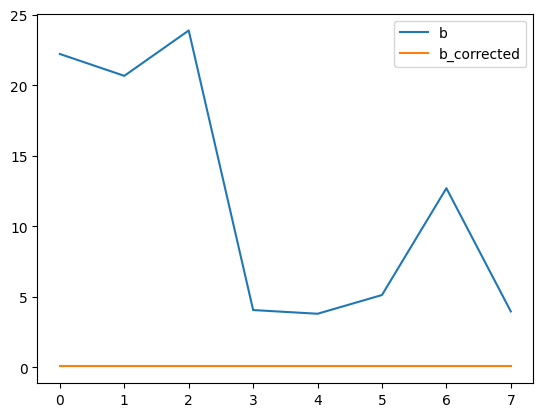

In [35]:
plt.plot(min_eig_b, label="b")
plt.plot(min_eig_b_corrected, label="b_corrected")
plt.legend()
plt.show()

In [13]:
# see magnitude of minimum eigenvalue
print("b min eigenvalue: ", np.amin(np.linalg.eig(b)[0]))
print("b_corrected min eigenvalue: ", np.amin(np.linalg.eig(b_corrected)[0]))

b min eigenvalue:  (1.6294332120407095e-14+1.0870574781273523e-15j)
b_corrected min eigenvalue:  (0.3867000202585436+0j)


In [22]:
# see magnitude of minimum eigenvalue
print("b min eigenvalue: ", np.amin(np.linalg.eig(b)[0]))
print("b_corrected min eigenvalue: ", np.amin(np.linalg.eig(b_corrected)[0]))

b min eigenvalue:  (-9.068982449957636+0j)
b_corrected min eigenvalue:  (-0.06329230487156828+0j)


In [7]:
# see magnitude of minimum eigenvalue
print("b min eigenvalue: ", np.amin(np.linalg.eig(b)[0]))
print("b_corrected min eigenvalue: ", np.amin(np.linalg.eig(b_corrected)[0]))

b min eigenvalue:  (5.412419351539658+0j)
b_corrected min eigenvalue:  0.17919761367657805


In [23]:
print(np.amax(np.linalg.eig(err)[0]))
print(np.amax(np.linalg.eig(err_corrected_1)[0]))
print(np.amax(np.linalg.eig(err_corrected_2)[0]))

(10.945524688862923+0.8235896665890766j)
(0.26916300148213324+0j)
(0.2691630014824791+0j)


In [39]:
print(np.linalg.norm(err, ord="fro"))
print(np.linalg.norm(err_corrected_1, ord="fro"))

112.31696709483555
0.38821215679861387


In [52]:
z_vec_1 = z_vec.reshape(-1, 1)
P_Z_1 = z_vec_1.dot(inv(z_vec_1.T.dot(z_vec_1)).dot(z_vec_1.T))

In [53]:
err_corrected_2 = np.reshape(P_Z_1 @ err.reshape([d1*d2, 1]), [d1, d2])

In [54]:
print(np.amax(np.linalg.eig(err_corrected_2)[0]))

(0.17281242907826072+0j)


In [56]:
print(np.linalg.norm(err_corrected_2, ord="fro"))

0.2346370184407353


In [49]:
print(z_vec.T @ err.reshape(d1*d2,))
print(h_z_vec.T @ err.reshape([d1*d2,1]))

680.1963654139653
[[26.34413531]]


In [88]:
HH = np.random.uniform(0, 100, [100, 100])

In [92]:
print(HH.reshape(-1,) @ err.reshape(-1,)/ np.linalg.norm(HH, ord="fro"))

0.3676710145965928


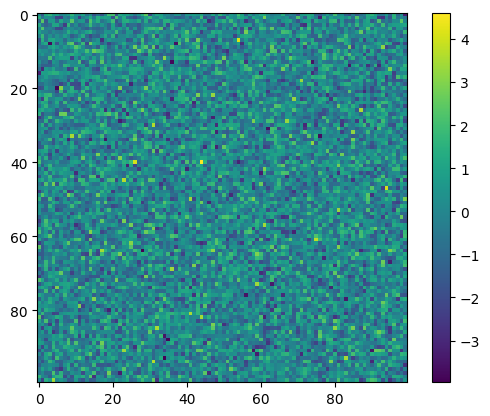

In [32]:
plt.imshow(err, interpolation='nearest')
plt.colorbar()
plt.show()

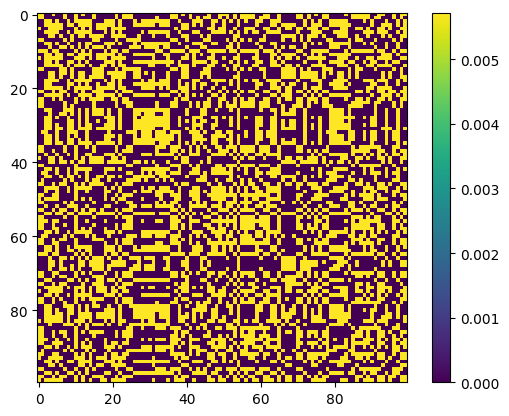

In [33]:
plt.imshow(err_corrected, interpolation='nearest')
plt.colorbar()
plt.show()

[[0.00021716 0.00021716 0.         ... 0.         0.00021716 0.00021716]
 [0.00021716 0.00021716 0.         ... 0.         0.00021716 0.00021716]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00021716 0.00021716 0.         ... 0.         0.00021716 0.00021716]
 [0.00021716 0.00021716 0.         ... 0.         0.00021716 0.00021716]]


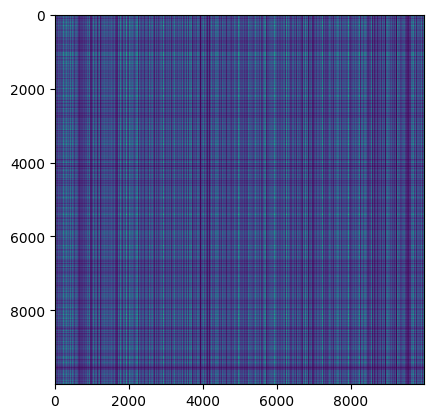

In [4]:
print(P_Z)
plt.imshow(P_Z)

In [5]:
np.linalg.matrix_rank(P_Z)

1

In [9]:
np.linalg.norm(P_Z - np.eye(P_Z.shape[0]))

99.99499987499902

## For original

In [104]:
s = np.linalg.svd(O, full_matrices = False, compute_uv=False)
suggest_r = np.sum(np.cumsum(s**2) / np.sum(s**2) <= 0.998)
pre_tau = np.sum(O*Z)/np.sum(Z)

In [102]:
num_treat = np.sum(Z)
u,s,vh = np.linalg.svd(O - tau*Z, full_matrices=False)

l_lst = [0, 5, 10, 20, 30, 40, 1000] # large lambda
for l in l_lst:
    s = np.maximum(s-l, 0) 
    M = (u*s).dot(vh)
    tau_new = np.sum(Z * (O - M)) / num_treat # update tau
    print("tau: ", tau_new)

tau:  2.0
tau:  2.005020862918812
tau:  2.0070211934450524
tau:  2.004143643984837
tau:  1.9966384402954074
tau:  1.9905233086106182
tau:  1.9907364195481079


In [101]:
num_treat

4834.0

In [107]:
num = 30
u,s,vh = np.linalg.svd(O - tau*Z, full_matrices=False)
l_max = s[0]
print("maximum singular value: ", l_max)
l_lst = np.linspace(1/num,l_max,num-1)
tau_lst = np.zeros(num-1)
info_lst = []
M_lst = []
for i, l in enumerate(l_lst):
    pre_M, tau_lst[i], info = DC_PR_with_l(O, Z, l, suggest_tau = pre_tau)
    info_lst.append(info)
    M_lst.append(pre_M)

maximum singular value:  112.88910021971851
tau in 0 iteration: 1.990791885030496
tau in 100 iteration: 1.9956394570106806
tau in 200 iteration: 1.9993206234877092
tau in 300 iteration: 2.00210846320034
tau in 400 iteration: 2.0042159299332534
tau in 500 iteration: 2.0058083593103175
tau in 600 iteration: 2.007051393335449
tau in 700 iteration: 2.0080397155512504
tau in 800 iteration: 2.008825506485523
tau in 900 iteration: 2.009450261982395
tau in 1000 iteration: 2.00994697903639
tau in 1100 iteration: 2.0103418952350576
tau in 1200 iteration: 2.0106558726806343
tau in 1300 iteration: 2.0109054988633406
tau in 0 iteration: 1.9974079327985763
tau in 0 iteration: 2.0018683997670066
tau in 0 iteration: 2.004151654764116
tau in 0 iteration: 2.005644724730187
tau in 0 iteration: 2.007211943293666
tau in 0 iteration: 2.00646414633198
tau in 0 iteration: 2.005476356629818
tau in 0 iteration: 2.0044885669276558
tau in 0 iteration: 2.0035007772254936
tau in 0 iteration: 2.002512987523331
tau i

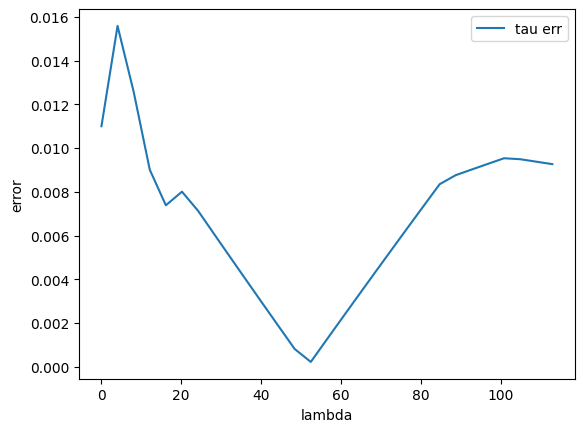

In [109]:
M_err = np.zeros(num-1)
for i in range(num-1):
    M_err[i] = np.linalg.norm(M_lst[i] - b)
tau_err = np.abs(tau_lst - tau)

plt.plot(l_lst, tau_err, label="tau err")
#plt.plot(l_lst, M_err, label="M err")
plt.legend()
plt.xlabel("lambda")
plt.ylabel("error")
plt.show()

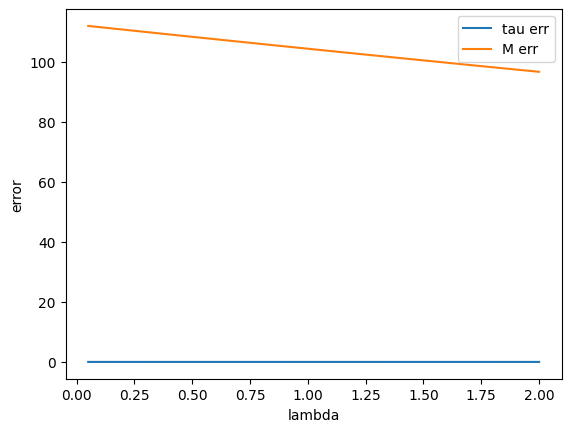

In [42]:
M_err = np.zeros(num-1)
for i in range(num-1):
    M_err[i] = np.linalg.norm(M_lst[i] - b)
tau_err = np.abs(tau_lst - tau)

plt.plot(l_lst, tau_err, label="tau err")
plt.plot(l_lst, M_err, label="M err")
plt.legend()
plt.xlabel("lambda")
plt.ylabel("error")
plt.show()

In [44]:
tau_err

array([0.03380036, 0.03520115, 0.03636635, 0.03719196, 0.03717228,
       0.03676419, 0.03654667, 0.03654466, 0.03665373, 0.03674031,
       0.03681175, 0.03674333, 0.03662479, 0.03652217, 0.03650992,
       0.03651728, 0.03665039, 0.03676798, 0.0368617 ])

## For corrected

In [113]:
s = np.linalg.svd(O_corrected, full_matrices = False, compute_uv=False)
suggest_r = np.sum(np.cumsum(s**2) / np.sum(s**2) <= 0.998)
pre_tau = np.sum(O_corrected*Z_corrected)/np.sum(Z_corrected)

In [114]:
u,s,vh = np.linalg.svd(O_corrected - tau*Z_corrected, full_matrices=False)

In [116]:
l_max = s[0]
print("maximum lambda: ", l_max)
num = 40
l_lst = np.linspace(1/num,l_max,num-1)
tau_lst = np.zeros(num-1)
info_lst = []
M_lst = []
for i, l in enumerate(l_lst):
    pre_M, tau_lst[i], info = DC_PR_with_l(O_corrected, Z_corrected, l, suggest_tau = pre_tau)
    info_lst.append(info)
    M_lst.append(pre_M)

maximum lambda:  0.702747221226776
tau in 0 iteration: 1.9466505270588375
tau in 100 iteration: 0.7865743821030033
tau in 200 iteration: 0.3720303051760129
tau in 300 iteration: 0.2238916384171143
tau in 400 iteration: 0.1709538066869113
tau in 500 iteration: 0.15203630128736673
tau in 600 iteration: 0.1452760695429755
tau in 700 iteration: 0.142860278862712
tau in 800 iteration: 0.1419969882490941
tau in 900 iteration: 0.1416884885559525
tau in 1000 iteration: 0.1415782451927437
tau in 1100 iteration: 0.14153884937030764
tau in 0 iteration: 1.9475419465098267
tau in 100 iteration: 0.8517134401761827
tau in 200 iteration: 0.4601872980079407
tau in 300 iteration: 0.32027416468805425
tau in 400 iteration: 0.2702757539382902
tau in 500 iteration: 0.25240866013385566
tau in 600 iteration: 0.24602379637059188
tau in 700 iteration: 0.24374214465254587
tau in 800 iteration: 0.2429267890309639
tau in 900 iteration: 0.2426354190622655
tau in 1000 iteration: 0.2425312970614969
tau in 0 iteration

In [117]:
b_corrected = np.reshape(P_Z.dot(b.reshape([d1*d2, 1])), [d1, d2])

In [118]:
M_err = np.zeros(num-1)
for i in range(num-1):
    M_err[i] = np.linalg.norm(M_lst[i] - b_corrected)

In [119]:
tau_err = np.abs(tau_lst - tau)

In [120]:
tau_err

array([1.85846927, 1.75750295, 1.6565369 , 1.55558178, 1.45465875,
       1.3537564 , 1.25287084, 1.15207546, 1.05139681, 0.95080532,
       0.85038758, 0.75044251, 0.6512131 , 0.55350769, 0.45723417,
       0.36719964, 0.28827976, 0.2253453 , 0.18211514, 0.15520678,
       0.13604269, 0.12201817, 0.11087879, 0.10212244, 0.09450079,
       0.08773429, 0.08221261, 0.07722789, 0.07309488, 0.06941641,
       0.06573825, 0.0620605 , 0.05838331, 0.05470341, 0.05102674,
       0.04803503, 0.04607423, 0.04455866, 0.04354445])

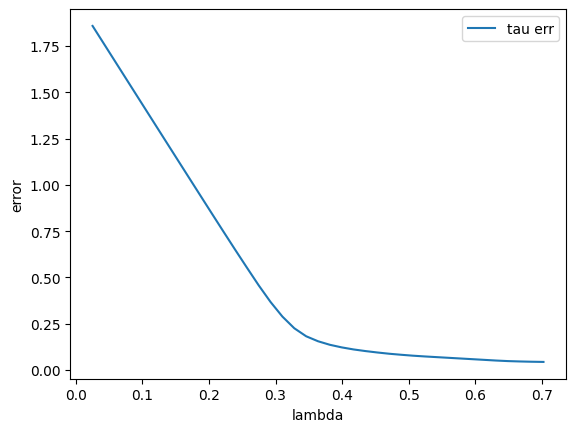

In [122]:
plt.plot(l_lst, tau_err, label="tau err")
#plt.plot(l_lst, M_err, label="M err")
plt.legend()
plt.xlabel("lambda")
plt.ylabel("error")
plt.show()

In [33]:
M_err

array([103.4896535 ,  86.24679591,  69.00889526,  51.77844039,
        34.57234835,  17.44140083,   3.38507754,   2.18716845,
         1.95227457,   1.82302494,   1.73767681,   1.6644637 ,
         1.59161934,   1.54978158,   1.53016238,   1.51068419,
         1.50267816,   1.49586477,   1.489099  ,   1.48235789,
         1.48145832,   1.48145832,   1.48145832,   1.48145832,
         1.48145832,   1.48145832,   1.48145832,   1.48145832,
         1.48145832,   1.48145832,   1.48145832,   1.48145832,
         1.48145832,   1.48145832,   1.48145832,   1.48145832,
         1.48145832,   1.48145832,   1.48145832,   1.48145832,
         1.48145832,   1.48145832,   1.48145832,   1.48145832,
         1.48145832,   1.48145832,   1.48145832,   1.48145832,
         1.48145832,   1.48145832,   1.48145832,   1.48145832,
         1.48145832,   1.48145832,   1.48145832,   1.48145832,
         1.48145832,   1.48145832,   1.48145832,   1.48145832,
         1.48145832,   1.48145832,   1.48145832,   1.48

In [ ]:
M_one, tau_one, M_raw_one, tau_raw_one, b_one, t1, t2, l_one = worker_proj(seed, d1, d2, r, tau, noise_sd)

In [11]:
## determine l
_, s, _ = np.linalg.svd(O_corrected-pre_tau*Z_corrected, full_matrices = False)
l = s[1]*1.1

In [12]:
l

0.07508744259446958